* Libraries

* Read In Data

* Data Preparation

* Modeling

    * LSTM

    * WaveNet

* Generate New Chorale

## Library

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import random

import tensorflow as tf

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## Read In Data

Downloads the Bach chorales dataset and unzips it.

In [3]:
tf.keras.utils.get_file(
    "data_bach_chorales.tgz",
    "https://github.com/ageron/data/raw/main/jsb_chorales.tgz",
    cache_dir=".",
    extract=True)

'.\\datasets\\data_bach_chorales.tgz'

In [4]:
path = Path("datasets/data_bach_chorales")
train = sorted(path .glob("train/chorale_*.csv"))
validation = sorted(path .glob("valid/chorale_*.csv"))
test = sorted(path .glob("test/chorale_*.csv"))


def load_data(filepaths):
    return [pd.read_csv(file).values.tolist() for file in filepaths]

train = load_data(train)
validation = load_data(validation)
test = load_data(test)

A separate test set is unnecessary for this task because I'll evaluate the model's performance by simply listening to the music it generates. Consequently, I'll merge the test set with the training data.

In [5]:
train = train + test

A typical chorale's length ranges from 100 to 640 time steps. Each time step consists of four integers, where each integer is associated with a piano note index. The value 0 represents the absence of a played note. Here's an illustration of what a chorale, drawn from the training set, might resemble:

In [6]:
random.choice(train)

[[71, 66, 63, 59],
 [71, 66, 63, 59],
 [71, 66, 63, 57],
 [71, 66, 63, 57],
 [71, 67, 64, 55],
 [71, 67, 64, 55],
 [71, 67, 64, 52],
 [71, 67, 64, 52],
 [69, 64, 57, 49],
 [69, 64, 57, 49],
 [67, 64, 57, 49],
 [67, 64, 57, 49],
 [66, 62, 57, 50],
 [66, 62, 57, 50],
 [66, 62, 57, 50],
 [66, 62, 57, 50],
 [71, 67, 62, 47],
 [71, 67, 62, 47],
 [71, 67, 62, 43],
 [71, 67, 62, 43],
 [69, 66, 62, 50],
 [69, 66, 62, 50],
 [67, 66, 62, 50],
 [67, 66, 62, 50],
 [66, 66, 60, 51],
 [66, 66, 60, 51],
 [66, 66, 59, 51],
 [66, 66, 59, 51],
 [67, 64, 59, 52],
 [67, 64, 59, 52],
 [67, 64, 59, 52],
 [67, 64, 59, 52],
 [71, 68, 64, 52],
 [71, 68, 64, 52],
 [71, 68, 64, 50],
 [71, 68, 64, 50],
 [71, 64, 64, 48],
 [71, 64, 64, 48],
 [71, 64, 64, 48],
 [71, 64, 64, 48],
 [69, 64, 57, 49],
 [69, 64, 57, 49],
 [67, 64, 57, 49],
 [67, 64, 57, 49],
 [66, 64, 57, 50],
 [66, 64, 57, 50],
 [66, 62, 57, 50],
 [66, 62, 57, 50],
 [71, 62, 53, 44],
 [71, 62, 53, 44],
 [71, 62, 53, 44],
 [71, 62, 53, 44],
 [69, 60, 52

Let's check the distribution of the notes in a sample of train data

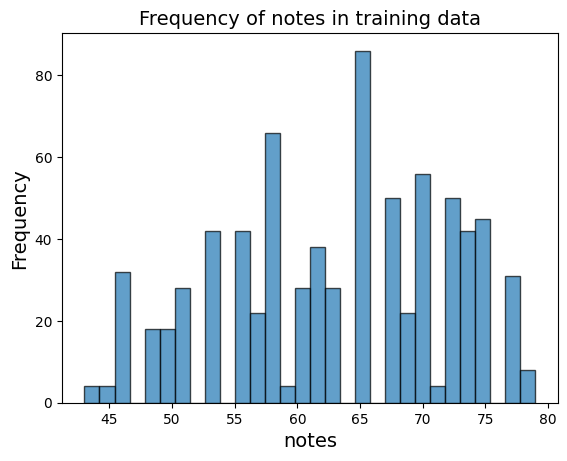

In [6]:
# Flatten the data
train_data_flat = np.array(train[0]).flatten()

# Create a histogram to visualize the data distribution
plt.hist(train_data_flat, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('notes')
plt.ylabel('Frequency')
plt.title(f"Frequency of notes in training data")

# Show the plot
plt.show()


Check the min and the max notes across train, validation , and test data.

In [7]:
notes = set()
for chorales in (train, validation, test):
    for chorale in chorales:
        for chord in chorale:
            notes |= set(chord)

n_notes = len(notes)
min_note = min(notes - {0})
max_note = max(notes)

assert min_note == 36
assert max_note == 81

In [8]:
n_notes 

47

The notes cover a span from 36 (representing C1, which is the C note in the first octave) to 81 (indicating A5, which is the A note in the fifth octave), with an additional value of 0 to denote silence.

In [9]:
#Thanks for the code from https://stackoverflow.com/questions/63974543/how-can-i-play-music-represented-as-chords-in-a-csv-file-with-python

from IPython.display import Audio

def notes_to_frequencies(notes):
    # Frequency doubles when you go up one octave; there are 12 semi-tones
    # per octave; Note A on octave 4 is 440 Hz, and it is note number 69.
    return 2 ** ((np.array(notes) - 69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo # the tempo is measured in beats per minutes
    # To reduce click sound at every beat, we round the frequencies to try to
    # get the samples close to zero at the end of each note.
    frequencies = (note_duration * frequencies).round() / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # Removing all notes with frequencies ≤ 9 Hz (includes note 0 = silence)
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]] # make last note a bit longer
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo # fade out last note
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100, filepath=None):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        from scipy.io import wavfile
        samples = (2**15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))

In [ ]:
for index in range(5):
    play_chords(train[index])

## Data Preparation

To enable the generation of new chorales, I aim to train a model capable of predicting the next note by considering the previous notes. Instead of predicting all four notes in a chord simultaneously, which can lead to dissonance, it's more effective to predict one note at a time. Consequently, I need to preprocess each chorale, transforming  each chorale into a long sequence of notes instead of chords. The training approach will involve a sequence-to-sequence model, where I provide a window of notes to the neural network, and it endeavors to forecast that same window shifted forward by one time step.

I will also adjust the note values within a range of 0 to 46, with 0 signifying silence, and values 1 to 46 corresponding to notes from C1 (36) to A5 (81).

The training process will employ windows of 128 notes, which is equivalent to 32 chords.

In [11]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:] # predict next note in each arpegio, at each step
    return X, Y

def preprocess(window):
    window = tf.where(window == 0, window, window - min_note + 1) # shift values within a range of 0 to 46
    return tf.reshape(window, [-1]) # convert into a long sequence of notes

def bach_dataset(chorales, batch_size=32, shuffle_buffer_size=None,
                 window_size=32, window_shift=16, cache=True):
    def batch_window(window):
        return window.batch(window_size + 1)

    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.flat_map(to_windows).map(preprocess)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    return dataset.prefetch(1)

In [12]:
train = bach_dataset(train, shuffle_buffer_size=1000)
validation = bach_dataset(validation)
test = bach_dataset(test)

## Modeling

To provide the model with note values, utilizing floating-point numbers directly might not yield optimal results. The relationships between notes are intricate; for instance, replacing a C3 with a C4 can still sound harmonious, despite the 12 semitones (one octave) difference. On the other hand, substituting a C3 with a C#3 often results in a discordant chord, even though these notes are adjacent on the piano.

To address this complexity, I will employ an Embedding layer in each model to convert each note into a compact vector representation. These embeddings will be five-dimensional, and the output of this initial layer will have a shape of [batch_size, window_size, 5].

In [13]:
embedding_dimensions = 5

### LSTM

In [14]:

lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_notes, output_dim=embedding_dimensions,
                           input_shape=[None]),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(n_notes, activation="softmax")
])

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 5)           235       
                                                                 
 lstm (LSTM)                 (None, None, 128)         68608     
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         131584    
                                                                 
 dense (Dense)               (None, None, 256)         33024     
                                                                 
 dense_1 (Dense)             (None, None, 47)          12079     
                                                                 
Total params: 245,530
Trainable params: 245,530
Non-trainable params: 0
_________________________________________________________________


In [15]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)
lstm_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
lstm_model.fit(train, epochs=20, validation_data=validation)

Epoch 1/20
131/131 [==============================] - 18s 123ms/step - loss: 3.3842 - accuracy: 0.0799 - val_loss: 3.2104 - val_accuracy: 0.0960
Epoch 2/20
131/131 [==============================] - 15s 115ms/step - loss: 3.1044 - accuracy: 0.1195 - val_loss: 2.9756 - val_accuracy: 0.1429
Epoch 3/20
131/131 [==============================] - 15s 116ms/step - loss: 2.8235 - accuracy: 0.1732 - val_loss: 2.5851 - val_accuracy: 0.2537
Epoch 4/20
131/131 [==============================] - 15s 116ms/step - loss: 1.9463 - accuracy: 0.4388 - val_loss: 1.5272 - val_accuracy: 0.5604
Epoch 5/20
131/131 [==============================] - 15s 116ms/step - loss: 1.3942 - accuracy: 0.6002 - val_loss: 1.2842 - val_accuracy: 0.6328
Epoch 6/20
131/131 [==============================] - 15s 116ms/step - loss: 1.1895 - accuracy: 0.6605 - val_loss: 1.1221 - val_accuracy: 0.6846
Epoch 7/20
131/131 [==============================] - 15s 115ms/step - loss: 1.0495 - accuracy: 0.7013 - val_loss: 1.0085 - val_ac

### WaveNet

The neural network architecture will resemble a scaled-down version of WaveNet, consisting of a sequence of four Conv1D layers with increasing dilation rates. BatchNormalization layers will be inserted between these convolutional layers to enhance training convergence. Following this, there will be one LSTM layer to capture longer-term patterns, and a Dense layer to generate the ultimate note probabilities. Each probability will correspond to an individual chorale in the batch, for each time step, and for every potential note, including silence. Consequently, the output shape will be [batch_size, window_size, 47].

In [16]:
import keras.backend as K
K.clear_session()


wavenet_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_notes, output_dim=embedding_dimensions,
                           input_shape=[None]),
    tf.keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu"),
    tf.keras.layers.BatchNormalization(),

    
    tf.keras.layers.Conv1D(128, kernel_size=2, padding="causal", activation="relu",dilation_rate=2),
    tf.keras.layers.BatchNormalization(),

    
    tf.keras.layers.Conv1D(256, kernel_size=2, padding="causal", activation="relu",dilation_rate=4),
    tf.keras.layers.BatchNormalization(),
 
    tf.keras.layers.Conv1D(512, kernel_size=2, padding="causal", activation="relu",dilation_rate=8),
    tf.keras.layers.BatchNormalization(),
 
    
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.Dense(n_notes, activation="softmax")
])

wavenet_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 5)           235       
                                                                 
 conv1d (Conv1D)             (None, None, 64)          704       
                                                                 
 batch_normalization (BatchN  (None, None, 64)         256       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         16512     
                                                                 
 batch_normalization_1 (Batc  (None, None, 128)        512       
 hNormalization)                                                 
                                                                 
 conv1d_2 (Conv1D)           (None, None, 256)         6

In [17]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)
wavenet_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
wavenet_model.fit(train, epochs=20, validation_data=validation)

Epoch 1/20


131/131 [==============================] - 66s 482ms/step - loss: 1.1441 - accuracy: 0.7082 - val_loss: 3.7478 - val_accuracy: 0.0786
Epoch 2/20
131/131 [==============================] - 64s 492ms/step - loss: 0.5891 - accuracy: 0.8280 - val_loss: 3.7355 - val_accuracy: 0.0948
Epoch 3/20
131/131 [==============================] - 66s 504ms/step - loss: 0.4886 - accuracy: 0.8530 - val_loss: 3.0460 - val_accuracy: 0.2215
Epoch 4/20
131/131 [==============================] - 63s 484ms/step - loss: 0.4230 - accuracy: 0.8709 - val_loss: 1.5807 - val_accuracy: 0.5327
Epoch 5/20
131/131 [==============================] - 61s 464ms/step - loss: 0.3672 - accuracy: 0.8872 - val_loss: 0.6891 - val_accuracy: 0.8035
Epoch 6/20
131/131 [==============================] - 61s 464ms/step - loss: 0.3224 - accuracy: 0.9007 - val_loss: 0.5797 - val_accuracy: 0.8338
Epoch 7/20
131/131 [==============================] - 61s 465ms/step - loss: 0.2862 - accuracy: 0.9111 - val_loss: 0.5928 - val_accuracy: 0.8

(I will not fine-tuning because the purpose of this notebook is to pratice the end to end pipeline of the sequence model. )

---

## Generate New Chorale

Create a function that generates a novel chorale. I'll input a set of initial chords, transform them into a sequence (as required by the model), and employ the model to forecast the following note in a sequential fashion. Subsequently, I'll group the notes in sets of four to recreate chords and then return the resulting chorale. However, using the model directly presents a risk-averse behavior, as it invariably selects the note with the highest score. Typically, this results in an over-repetition of the previous note, leading to a rather uninteresting musical output. To add more variety, I'll opt for a randomized approach. Instead of always favoring the highest-scoring note, I will make the next note selection based on the predicted probabilities. For instance, if the model suggests a C3 with a 75% probability and a G3 with a 25% probability, it will choose one of these notes randomly, with their respective probabilities considered in the selection process. I'll add a rate parameter. A high rate will bring the predicted probabilities closer together, reducing the probability of the likely notes and increasing the probability of the unlikely ones.

In [26]:

def my_chorale(model, initial_chords, length, rate=1):
    sequence_notes = preprocess(tf.constant(initial_chords, dtype=tf.int64))
    sequence_notes = tf.reshape(sequence_notes, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note_probas = model.predict(sequence_notes)[0, -1:]
            rescaled_logits = tf.math.log(next_note_probas) / rate
            next_note = tf.random.categorical(rescaled_logits, num_samples=1)
            sequence_notes = tf.concat([sequence_notes, next_note], axis=1)
    sequence_notes = tf.where(sequence_notes == 0, sequence_notes, sequence_notes + min_note - 1)
    return tf.reshape(sequence_notes, shape=[-1, 4])

Utilize the initial 8 chords from one of the test chorales, which essentially consists of two distinct chords, each played four times.

In [27]:
test_files = sorted(path.glob("test/chorale_*.csv"))
test_chorales = load_data(test_files)

In [ ]:
initial_chords = test_chorales[2][:8]
play_chords(initial_chords, amplitude=0.2)

In [ ]:
new_chorale1 = my_chorale(wavenet_model, initial_chords, 56, 0.8)
play_chords(new_chorale1)

In [ ]:
new_chorale2 = my_chorale(wavenet_model, initial_chords, 56, 1.5)
play_chords(new_chorale2)

In [ ]:
play_chords(test_chorales[2][:64], filepath="original_chorale.wav")

In [ ]:
play_chords(new_chorale2, filepath="new_chorale_.wav")
